In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
import pandas as pd

tkwargs = (
    {  # Dictionary containing information about data type and data device
        "dtype": torch.double,
        "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    }
)
# Writing the dictionary to a DataFrame
df = pd.DataFrame([tkwargs])
# Saving the DataFrame to a CSV file, this will be read by other functions.
df.to_csv('data/tkwargs.csv', index=False)

from bo_code.BO import BO_round
from bo_code.MTBO import generate_initial_data_mtgp, MTBO_round

from rm_code.crf import resolution_score_2D
from rm_code.retention_model import online_system, offline_system
from rm_code.plot_chromatogram import plot_chromatogram, plot_contour_spectrum,  plot_shifting_2D_gradient

from utils.utils import bo_to_rm_2D, check_pars, seed_everything, best_so_far, ci

/home/jimboelrijk/mambaforge/envs/MultiTask2DLC/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 4.5 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 1000 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

# Try out a 1D gradient
phi_list_1D = [0.15, 0.35, 1, 1] # phi values
t_list_1D = [0, 20, 40, 100] # time values

### Set up a 2D retention model

### Define 2D parameters
# lower bounds of shifting gradients are named "init". upper bounds of shifting gradients aer named "final".
# time points of each shift have to be same in the current setup. Shift starts after the dead time of the first dimension. Shift ends at the end of the 1D program
# each gradient in the second dimension has a dead time, gradient time and modulation time.

N_2D = 5000 # plate number 2D

t_M_2D = 2 #/ 3 # modulation time minutes
t_G_2D = 1.8 #/ 3 # gradient time minutes
t_init_2D = 0.1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# Try out a shifting gradient
phi_init_2D = [0.05, 0.05, 0.15, 0.6, 0.7]
phi_final_2D = [0.1, 0.1, 0.3, 0.9, 1]
t_list_2D = [0, t_0_1D, 40, 45, t_list_1D[-1]]

# maximum allowed times in first and second dimension
max_T = [t_list_1D[-1], t_M_2D]
# check if the parameters are valid
check_pars(settings_2D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D)

In [19]:
# number of analytes
n_analytes = 80

# Load the retention parameters created in "samplin_retention_paremters.ipynb"
ret_pars = pd.read_csv('data/retention_system.csv').to_dict(orient='list')

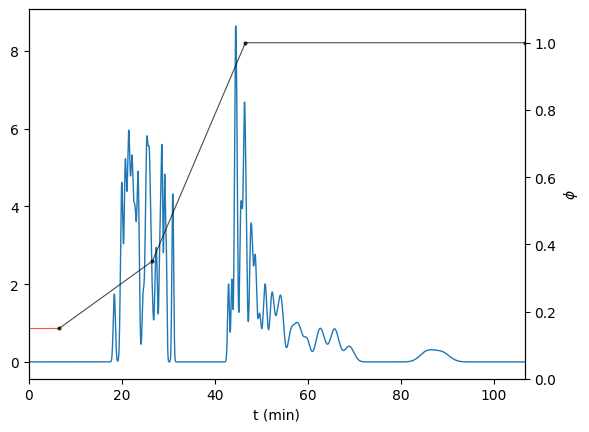

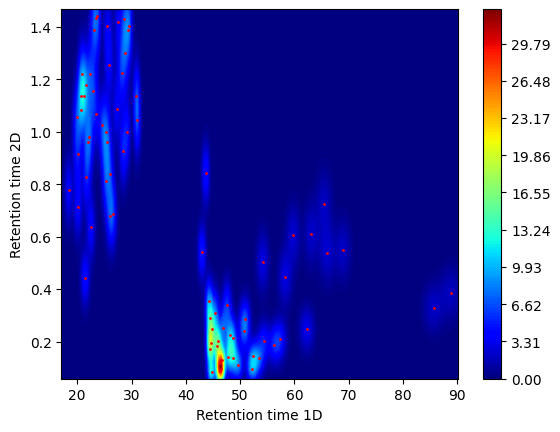

Score 67.02671109025565 88.80217834302763


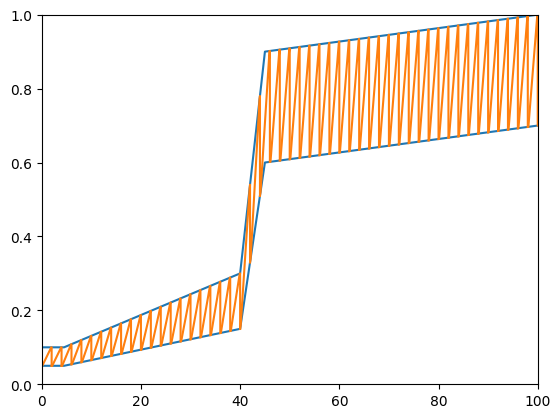

In [20]:
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D, max_T)

# plot chromatograms
plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D, t_list_1D, settings_1D)

plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)

plot_shifting_2D_gradient(settings_2D, phi_init_2D, phi_final_2D, t_list_2D)

print('Score', res_score, time_score)

baseline = res_score - 0.1 * time_score

In [7]:
# Optimization code

# Set some fixed parameters
t_max = 100 # maximum time
phi_min, phi_max = 0, 1 # maximum phi
fixed_phi_pars_1D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_1D = torch.tensor([[0.], [t_max]]) # at fixed time points

fixed_phi_pars_2D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_2D = torch.tensor([[0.],[t_0_1D], [t_max]]) # at fixed time points

# We will optimize 12 parameters, 4 parameters (2 gradient turning points) in the first dimension.
# And 8 parameters in the second dimension, two time points, and three phi_init and phi_final point of the shifting gradient.
# Pars vector will look like this: [phi1, phi2, t1, t2, phi_i1, phi_i2, phi_i3, phi_f1, phi_f2, phi_f3, t1_shift, t2_shift]
bounds = torch.stack([
    torch.tensor([phi_min, phi_min, 0.1, 0.1, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D]),
    torch.tensor([phi_max, phi_max, t_max-0.1, t_max-0.1, phi_max, phi_max, phi_max, phi_max, phi_max, phi_max, t_max-t_M_2D, t_max-t_M_2D])]
)

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(12), torch.ones(12)])

# We will also need to set some inequality constraints : 1. phi_i1 < phi_f2, 2. phi_i2 < phi_f3,
# 3. t1 < t2, 4. phi1 < phi2,  5. -t1_shift + t2_shift > tM
# Spare representation of BoTorch.
# ([indices of parameters], [coefficients], constant), example: ((torch.tensor([0,1]), torch.tensor([-1., 1.]), 0.0)) -x0 + x1 >= 0
inequality_constraints= [(torch.tensor([0,1]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([2,3]), torch.tensor([-1., 1.]), torch.tensor(0.1)), (torch.tensor([10,11]), torch.tensor([-1., 1.]), torch.tensor(t_M_2D)), (torch.tensor([4,8]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([5,9]), torch.tensor([-1., 1.]), torch.tensor(0.0))]

# draw 10 random indices between 0 and n_analytes
remove_indices = np.random.randint(0, n_analytes, 10)
# create dictionary with noise levels
noise = {'tR_1D': 2, 'tR_2D': 0.1, 'W_1D': 0.2, 'W_2D': 0.05}

In [10]:
# Set up an online only BO loop

# generate initial samples
n_init_online = 10
n_init_offline = 20

# optimization budget
iterations = 5
n_online = 1
n_offline = 5

# number of trials
trials = 2

# create some lists to store results in
scores_all_single_task = []
scores_all_online_mt = []
scores_all_offline_mt = []
scores_all_random = []

pars_all_single_task = []
pars_all_online_mt = []
pars_all_offline_mt = []
pars_all_random = []

# Loop over trials
for trial in range(trials):
    # print trial number out of total
    print('Trial', trial+1, 'out of', trials)

    # Set random seed for reproducibility
    seed_everything(trial)

    # create lists to fill with results per trial
    scores_single_task = []
    scores_online_mt = []
    scores_offline_mt = []
    scores_random = []

    pars_single_task = []
    pars_online_mt = []
    pars_offline_mt = []
    pars_random = []

    # generate parameters for initial experiments
    pars_online_init, pars_offline_init = generate_initial_data_mtgp(n_init_online, n_init_offline, bounds, inequality_constraints)

    # Perform initial online experiments
    phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(pars_online_init, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

    for i in range(len(pars_online_init)):

        tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_init_2D[i], phi_final_2D[i], t_list_2D[i], max_T)

        # now we need to add the pars and scores to online_mt and single_task as they will both share the same initial experiments
        scores_online_mt.append(res_score - 0.1*time_score)
        pars_online_mt.append(pars_online_init[i])

        scores_single_task.append(res_score - 0.1*time_score)
        pars_single_task.append(pars_online_init[i])

        scores_random.append(res_score - 0.1*time_score)
        pars_random.append(pars_online_init[i])

    # Perform initial offline experiments
    phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(pars_offline_init, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

    for i in range(len(pars_offline_init)):

        tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_init_2D[i], phi_final_2D[i], t_list_2D[i], max_T, noise, remove_indices)

        # now we need to add the pars and scores to offline_mt
        scores_offline_mt.append(res_score - 0.1*time_score)
        pars_offline_mt.append(pars_offline_init[i])

        #print(res_score)
    print('Done with initial random experiments')

    print('Starting Random Strategy')
    #RANDOM STRATEGY
    for iteration in tqdm(range(iterations)):
        # draw random parameters
        new_pars_random, _ = generate_initial_data_mtgp(n_online, n_offline, bounds, inequality_constraints)
        # convert to parameters that retention modeling code can handle
        phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(new_pars_random, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

        for i in range(len(new_pars_random)):
            # Perform new experiment
            tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T)

            # now we need to add the pars and scores to online_mt
            scores_random.append(res_score - 0.1*time_score)
            pars_random.append(new_pars_random[i])

    print('Starting Single Task BO loop')
    # SINGLE TASK BO
    for iteration in tqdm(range(iterations)):
        # perform BO round
        new_pars_so = BO_round(bounds, norm_bounds, inequality_constraints, scores_single_task, pars_single_task, n_online)
        #print(len(new_pars_so))
        # convert to parameters that retention modeling code can handle
        phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(new_pars_so, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

        for i in range(len(new_pars_so)):
            # Perform new experiment
            tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T)


            # now we need to add the pars and scores to online_mt
            scores_single_task.append(res_score - 0.1*time_score)
            pars_single_task.append(new_pars_so[i])

    # MULTI TASK BO
    #Now this will look different, as it will be a combination of online and offline experiments, and they need to be evaluated in the function.
    print('Starting Multi Task BO loop')
    for iteration in tqdm(range(iterations)):
        # perform MTBO round and query for n_offline experiments. These are obtained by optimizing an acquisition function on the online model.
        new_pars_mt_offline = MTBO_round(scores_online_mt, scores_offline_mt, pars_online_mt, pars_offline_mt, n_online, n_offline, bounds, inequality_constraints, mode="offline")

        #print('NEW PARS ', new_pars_mt_offline.shape)
        # convert to parameters that retention modeling code can handle
        phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(new_pars_mt_offline, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

        # perform experiments on the offline system
        for i in range(len(new_pars_mt_offline)):
            # Perform new experiment
            tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T, noise, remove_indices)

            # now we need to add the pars and scores to offline_mt
            scores_offline_mt.append(res_score - 0.1*time_score)
            pars_offline_mt.append(new_pars_mt_offline[i])


        # Now we need to update the MTGP model and check which design point is best on the online model posterior using the UCB acquisition function
        new_pars_mt_online = MTBO_round(scores_online_mt, scores_offline_mt, pars_online_mt, pars_offline_mt, n_online, n_offline,  bounds, inequality_constraints, mode="online")

        #print('NEW PARS ', new_pars_mt_online.shape)
        #print('NEW PARS ', new_pars_mt_online)
        # convert to parameters that retention modeling code can handle
        phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(new_pars_mt_online, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

        # perform this experiment on the online system
        for i in range(len(new_pars_mt_online)):
            # Perform new experiment
            tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_list_init[i], phi_list_final[i], t_list_2D[i], max_T)

            # now we need to add the pars and scores to online_mt
            scores_online_mt.append(res_score - 0.1*time_score)
            pars_online_mt.append(new_pars_mt_online[i])

    # update lists
    scores_all_single_task.append(scores_single_task)
    scores_all_online_mt.append(scores_online_mt)
    scores_all_offline_mt.append(scores_offline_mt)
    scores_all_random.append(scores_random)

    pars_all_single_task.append(pars_single_task)
    pars_all_online_mt.append(pars_online_mt)
    pars_all_offline_mt.append(pars_offline_mt)
    pars_all_random.append(pars_random)


Trial 1 out of 2
Done with initial random experiments
Starting Random Strategy


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Starting Single Task BO loop


100%|██████████| 5/5 [01:05<00:00, 13.01s/it]


Starting Multi Task BO loop


100%|██████████| 5/5 [04:00<00:00, 48.19s/it]


Trial 2 out of 2
Done with initial random experiments
Starting Random Strategy


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Starting Single Task BO loop


100%|██████████| 5/5 [00:58<00:00, 11.63s/it]


Starting Multi Task BO loop


100%|██████████| 5/5 [05:28<00:00, 65.76s/it]


## Some visualization of results

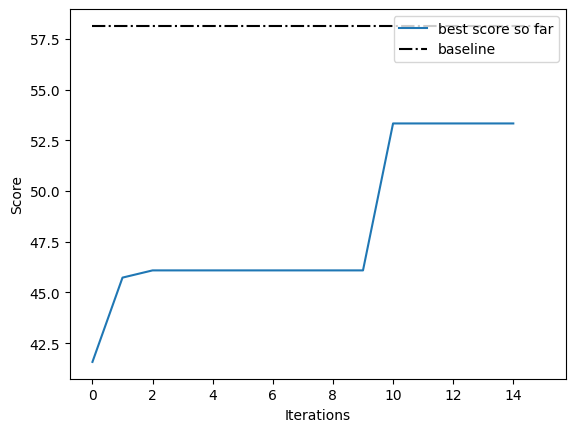

Best score:  53.33631079058375


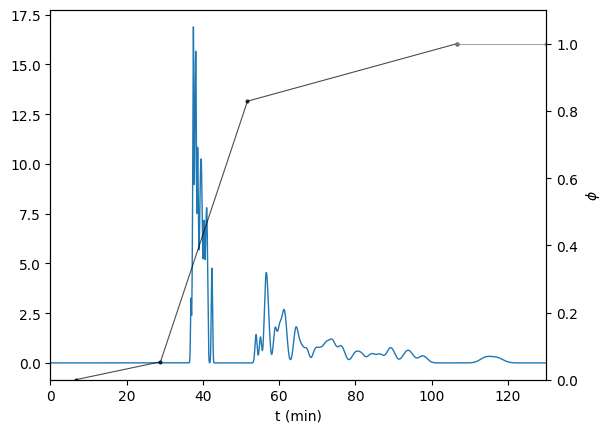

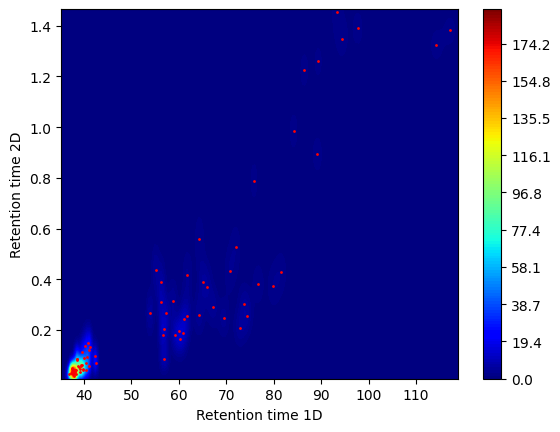

65.05702609134268 65.05702609134268


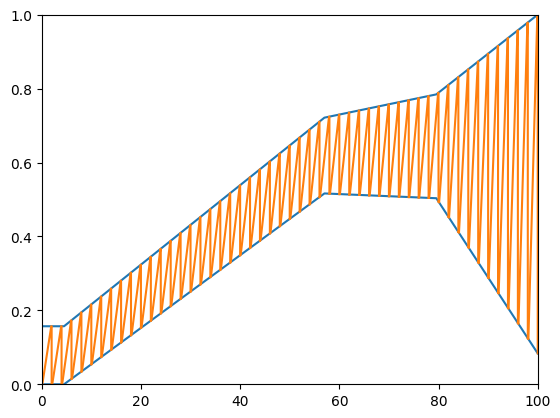

In [21]:
scores_best_so_far = best_so_far(np.array(scores_all_single_task))

trial_to_observe = 0
# plot best observed scores at each iteration
plt.plot(scores_best_so_far[trial_to_observe], label='best score so far')

# plot score of handpicked program
plt.hlines(baseline, 0, len(np.array(scores_all_single_task)[trial_to_observe]), ls='-.', label='baseline', color='black')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.show()

# plot the best measurement (according to score function)
idxloc = np.argmax(scores_all_single_task[trial_to_observe])
print('Best score: ', scores_all_single_task[trial_to_observe][idxloc])
best_pars = pars_all_single_task[trial_to_observe][idxloc].unsqueeze(0)

# convert best pars to parameters that retention modeling code can handle
phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(best_pars, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

# perform experiments using online system
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[0], t_list_1D[0],phi_list_init[0], phi_list_final[0], t_list_2D[0], max_T)

# plot chromatograms
plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D[0], t_list_1D[0], settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_list_init[0], phi_list_final[0], t_list_2D[0])

# compute scores
_, _, _, resolutions_score = resolution_score_2D(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_time=[100, t_M_2D])
print(res_score, resolutions_score)


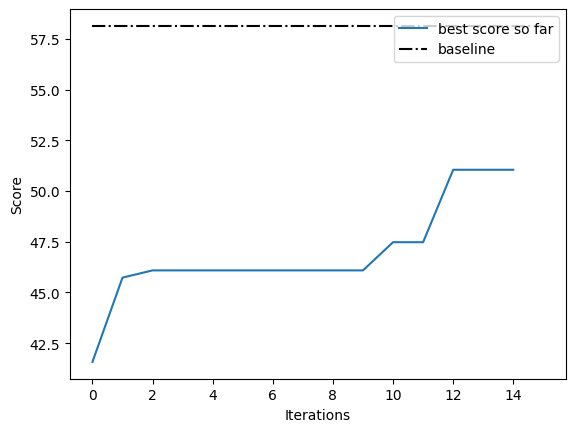

Best score:  51.051860089963675


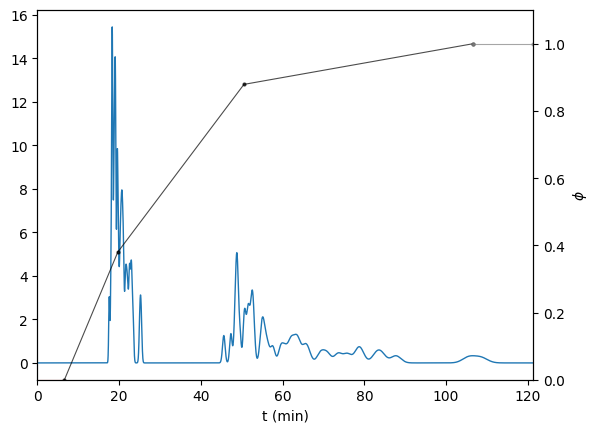

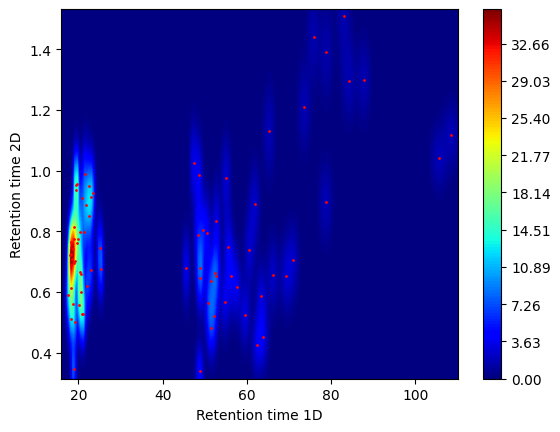

61.90147071700538 61.90147071700538


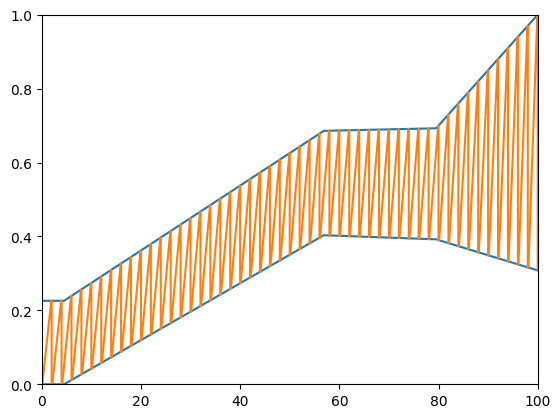

In [22]:
# scores_all_online_mt = torch.from_numpy(np.load('data/noffline20_scores_all_online_mt.npy'))
#
# pars_all_online_mt = torch.from_numpy(np.load('data/noffline20_pars_all_online_mt.npy'))

scores_best_so_far = best_so_far(np.array(scores_all_online_mt))

trial_to_observe = 0
# plot best observed scores at each iteration
plt.plot(scores_best_so_far[trial_to_observe], label='best score so far')

# plot score of handpicked program
#baseline = score_ms * prefacs[0] + time_score_ms * prefacs[1]
plt.hlines(baseline, 0, len(scores_all_online_mt[trial_to_observe]), ls='-.', label='baseline', color='black')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.show()

# plot the best measurement (according to score function)
idxloc = np.argmax(scores_all_online_mt[trial_to_observe])
print('Best score: ', scores_all_online_mt[trial_to_observe][idxloc])
best_pars = pars_all_online_mt[trial_to_observe][idxloc].unsqueeze(0)

# convert best pars to parameters that retention modeling code can handle
phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(best_pars, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

# perform experiments using online system
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[0], t_list_1D[0],phi_list_init[0], phi_list_final[0], t_list_2D[0], max_T)

# plot chromatograms
plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D[0], t_list_1D[0], settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_list_init[0], phi_list_final[0], t_list_2D[0])

# compute scores
_, _, _, resolutions_score = resolution_score_2D(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_time=[100, t_M_2D])
print(res_score, resolutions_score)

In [23]:
# save results
# np.save('data/noffline20_scores_all_single_task.npy', scores_all_single_task)
# np.save('data/noffline20_scores_all_online_mt.npy', scores_all_online_mt)
# np.save('data/noffline20_scores_all_offline_mt.npy', scores_all_offline_mt)
# np.save('data/noffline20_scores_all_random.npy', scores_all_random)
#
# np.save('data/noffline20_pars_all_single_task.npy', pars_all_single_task)
# np.save('data/noffline20_pars_all_online_mt.npy', pars_all_online_mt)
# np.save('data/noffline20_pars_all_offline_mt.npy', pars_all_offline_mt)
# np.save('data/noffline20_pars_all_random.npy', pars_all_random)

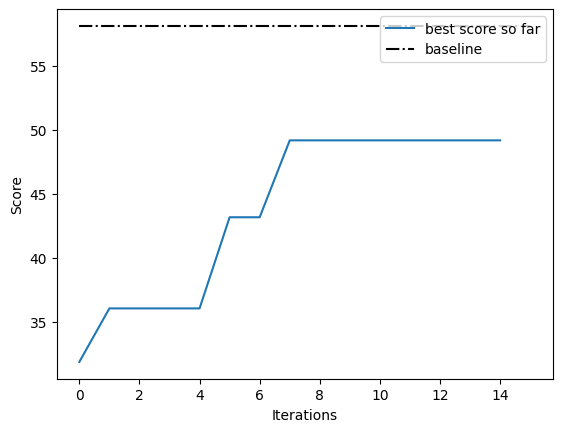

Best score:  49.18833500396068


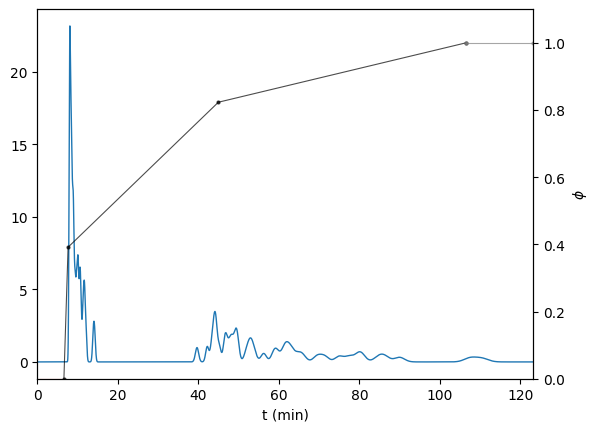

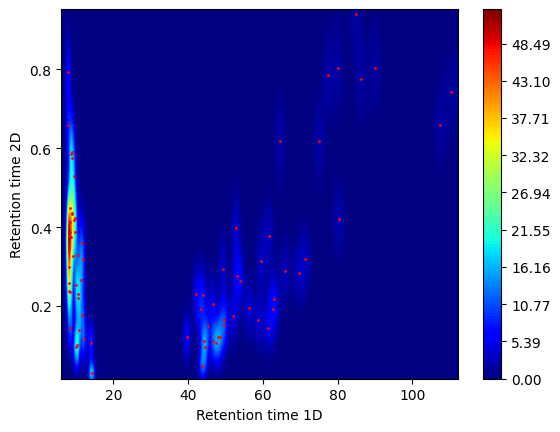

60.22634865960871 60.22634865960871


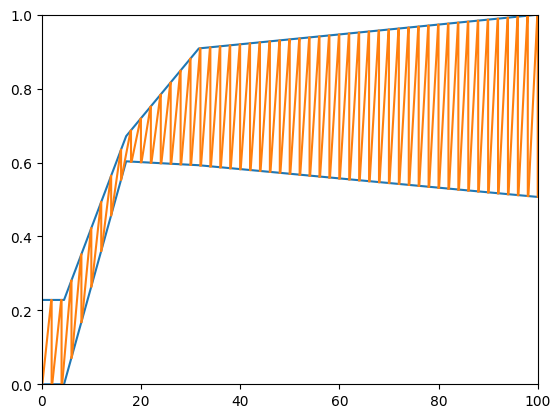

In [24]:
scores_best_so_far = best_so_far(np.array(scores_all_random))

trial_to_observe = 1
# plot best observed scores at each iteration
plt.plot(scores_best_so_far[trial_to_observe], label='best score so far')

# plot score of handpicked program
#baseline = score_ms * prefacs[0] + time_score_ms * prefacs[1]
plt.hlines(baseline, 0, len(scores_all_random[trial_to_observe]), ls='-.', label='baseline', color='black')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.show()

# plot the best measurement (according to score function)
idxloc = np.argmax(scores_all_random[trial_to_observe])
print('Best score: ', scores_all_random[trial_to_observe][idxloc])
best_pars = pars_all_random[trial_to_observe][idxloc].unsqueeze(0)

# convert best pars to parameters that retention modeling code can handle
phi_list_1D, t_list_1D, phi_list_init, phi_list_final, t_list_2D = bo_to_rm_2D(best_pars, fixed_phi_pars_1D,
                                                                               fixed_time_pars_1D, fixed_phi_pars_2D,
                                                                               fixed_time_pars_2D)

# perform experiments using online system
tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D,
                                                                        phi_list_1D[0], t_list_1D[0], phi_list_init[0],
                                                                        phi_list_final[0], t_list_2D[0], max_T)

# plot chromatograms
plot_chromatogram(tR_list_1D, W_list_1D, phi_list_1D[0], t_list_1D[0], settings_1D)
plot_contour_spectrum(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_T)
plot_shifting_2D_gradient(settings_2D, phi_list_init[0], phi_list_final[0], t_list_2D[0])

# compute scores
_, _, _, resolutions_score = resolution_score_2D(tR_list_1D, tR_list_2D, W_list_1D, W_list_2D, max_time=[100, t_M_2D])
print(res_score, resolutions_score)

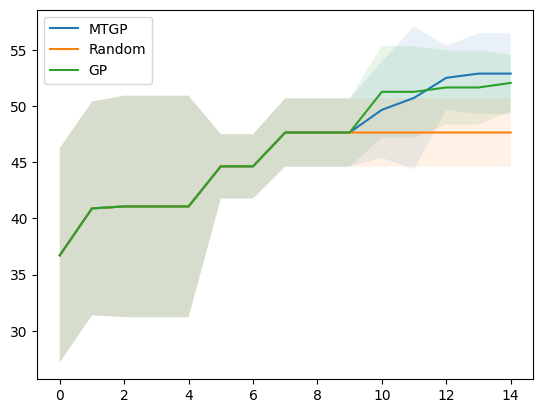

In [26]:
# plot score curves for all trials and all variations using best so far and using mean and std
scores_best_so_far_mtgp = best_so_far(np.array(scores_all_online_mt))
scores_best_so_far_random = best_so_far(np.array(scores_all_random))
scores_best_so_far_gp = best_so_far(np.array(scores_all_single_task))

# plot score curves for all trials and all variations using best so far and using mean and std, using ci() function
scores_mean_mtgp = np.mean(np.array(scores_best_so_far_mtgp), axis=0)
scores_ci_mtgp = ci(np.array(scores_best_so_far_mtgp),1)

scores_mean_random = np.mean(np.array(scores_best_so_far_random), axis=0)
scores_ci_random = ci(np.array(scores_best_so_far_random), 1)

scores_mean_gp = np.mean(np.array(scores_best_so_far_gp), axis=0)
scores_ci_gp = ci(np.array(scores_best_so_far_gp),1)

plt.plot(scores_mean_mtgp, label='MTGP')
plt.fill_between(np.arange(len(scores_mean_mtgp)), scores_mean_mtgp - scores_ci_mtgp, scores_mean_mtgp + scores_ci_mtgp, alpha=.1)

plt.plot(scores_mean_random, label='Random')
plt.fill_between(np.arange(len(scores_mean_random)), scores_mean_random - scores_ci_random, scores_mean_random + scores_ci_random, alpha=.1)

plt.plot(scores_mean_gp, label='GP')
plt.fill_between(np.arange(len(scores_mean_gp)), scores_mean_gp - scores_ci_gp, scores_mean_gp + scores_ci_gp, alpha=.1)

plt.legend()
plt.show()

In [27]:
print(np.array(scores_all_single_task).shape)
print(scores_best_so_far_gp.shape)

print(np.array(scores_all_online_mt).shape)

(2, 15)
(2, 15)
(2, 15)


In [ ]:
#TODO: try Thompson sampling instead of UCB to make it more random.

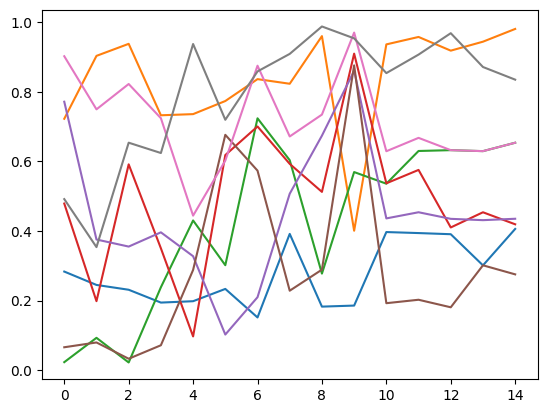

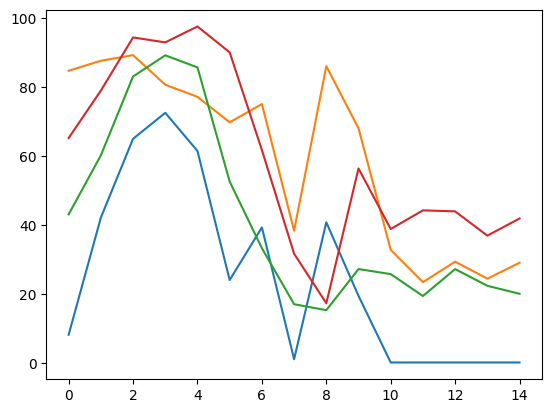

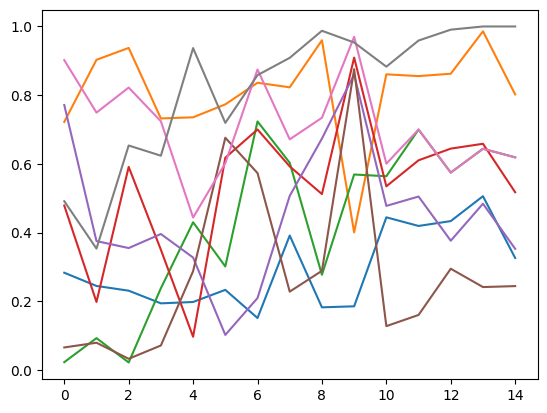

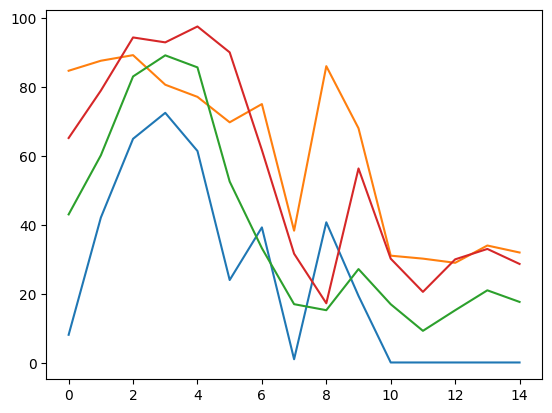

In [29]:
# scatter plot the pars of the mtgp
low_indices = [0, 1, 4, 5, 6, 7, 8, 9]
high_indices = [2, 3, 10, 11]

trial = 1

plt.plot(torch.stack(pars_all_online_mt[trial])[:, low_indices].numpy())
plt.show()
plt.plot(torch.stack(pars_all_online_mt[trial])[:, high_indices].numpy())
plt.show()

plt.plot(torch.stack(pars_all_single_task[trial])[:, low_indices].numpy())
plt.show()
plt.plot(torch.stack(pars_all_single_task[trial])[:, high_indices].numpy())
plt.show()


In [ ]:
plt.plot(torch.stack(pars_all_single_task[0]).numpy())


In [ ]:
#import pickle
#pickle.dump(fig, open('FigureObject.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`

In [ ]:
# sample from the uniform distribution
pars = torch.rand(1, 2000)

plt.scatter(pars, 1-pars)

plt.hist(pars)
plt.hist(1-pars)

In [ ]:
#figx = pickle.load(open('FigureObject.fig.pickle', 'rb'))
#figx.show() # Show the figure, edit it, etc.!